# Bidirectional LSTM seq2seq model, "state of the art is usually BiLSTMs using Attention". This just uses BiLSTMs

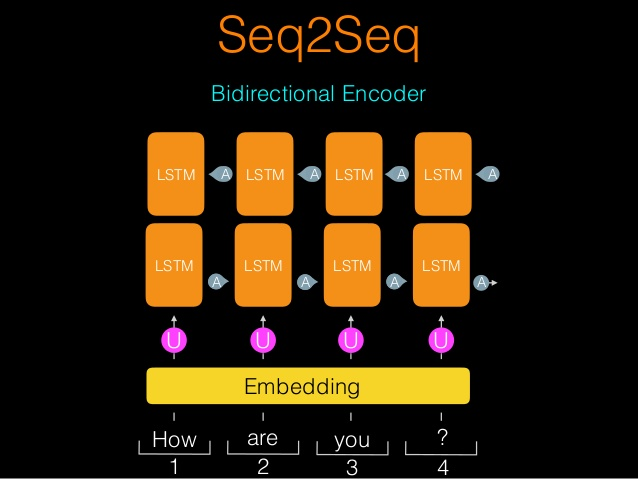

In [1]:
from IPython.display import Image
Image(filename='bi_seq2seq.jpg')
# image credits https://www.slideshare.net/samwit/tensor-flow05-neuralmachinetranslationseq2seq

In [2]:
import numpy as np  
import pandas as pd 
import re           
from bs4 import BeautifulSoup 
import nltk
# nltk.download('punkt')
# nltk.download('wordnet')
# nltk.download('stopwords')
from nltk import sent_tokenize, word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
import pandas as pd
import numpy as np
import re                      # Regular expressions
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from nltk.corpus import stopwords   
from tensorflow.keras.layers import Input, LSTM, Embedding, Dropout,  Dense, Activation,Add, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\R-k-l\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\R-k-l\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\R-k-l\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
Using TensorFlow backend.


### Perform the following tasks on the data:
- Convert everything to lowercase
- Remove HTML tags
- Contraction mapping
- Remove (‘s)
- Remove any text inside the parenthesis ( )
- Eliminate punctuations and special characters
- Remove stopwords
- Remove shortwords

In [4]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

In [5]:
stop_words = set(stopwords.words('english')) 
def text_cleaner(text):
    """
    text (str): a string of text that can be multiple sentences to be parsed into a token stream. 
    Returns: a cleaned string of text
    """
    newString = text.lower()
    newString = BeautifulSoup(newString, exclude_encodings="lxml").text # removes html/xml taggs
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    tokens = [w for w in newString.split() if not w in stop_words]
    long_words=[]
    for i in tokens:
        if len(i)>=3:                  #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()


## Tokenize, Sequence, Pad

## Import data to train model on in csv format

In [9]:
df_art_sum = pd.read_csv("train_model_files/article_summary_and_article_title/sample_1000.csv")
# bbc_art_sum.drop("Unnamed: 0", axis=1, inplace=True)
print(df_art_sum.shape)
df_art_sum.head()

(1000, 2)


,article,title
0,"russian foreign minister igor ivanov said tuesday that he and new secretary of state colin powell will hold their first meeting on feb. ## in cairo , egypt .",ivanov powell to meet this month
1,"french aerobatic team `` patrouille de france '' will stage an exciting performance in hong kong on oct. ## during its first visit to china , according to a press release issued by the consulate g...",french aerobatic team to stage performance in hk
2,spanish farmers hurled several thousand kilos -lrb- pounds -rrb- of tomatoes and eggs at the french embassy on saturday in reprisal for attacks on spanish produce in france .,spanish farmers hurl produce at french embassy
3,"european share retreated thursday , tracking declines on wall street , with technology stocks posting heavy losses after a bearish earnings outlook from nokia for the fourth quarter .",euro stocks slip on wall street losses nokia
4,a judge on wednesday said he will not impanel a new jury to decide whether to spare the life a man convicted in the bombing of a u.s. embassy in africa .,embassy bombings judge to keep jury


## Tokenize list data into sequences

In [10]:
from keras.preprocessing.text import Tokenizer
# articles = list(df_art_sum.row_article)
articles = list(df_art_sum.article)
# summaries = list(df_art_sum.summary)
summaries = list(df_art_sum.title)


# Article data
VOCAB_SIZE = 999
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(articles)
article_sequences = tokenizer.texts_to_sequences(articles)
art_word_index = tokenizer.word_index
print(len(art_word_index))

art_word_index_1500 = {}
counter = 0
for word in art_word_index.keys():
    if art_word_index[word] == 0:
        print("found 0!")
        break
    if art_word_index[word] > VOCAB_SIZE:
        continue
    else:
        art_word_index_1500[word] = art_word_index[word]
        counter += 1
print(counter)

# Summary data
tokenizer.fit_on_texts(summaries)
summary_sequences = tokenizer.texts_to_sequences(summaries)
sum_word_index = tokenizer.word_index
print(len(sum_word_index))

sum_word_index_1500 = {}
counter = 0
for word in sum_word_index.keys():
    if sum_word_index[word] == 0:
        print("found 0!")
        break
    if sum_word_index[word] > VOCAB_SIZE:
        continue
    else:
        sum_word_index_1500[word] = sum_word_index[word]
        counter += 1
print(counter)

6410
999
7123
999


In [11]:
art_word_index

{'the': 1,
 'a': 2,
 'of': 3,
 'to': 4,
 'in': 5,
 'and': 6,
 'on': 7,
 "'s": 8,
 'for': 9,
 'said': 10,
 'that': 11,
 'by': 12,
 'an': 13,
 'at': 14,
 'with': 15,
 'as': 16,
 'wednesday': 17,
 'from': 18,
 'his': 19,
 'is': 20,
 'has': 21,
 'thursday': 22,
 'its': 23,
 'will': 24,
 'after': 25,
 'tuesday': 26,
 'was': 27,
 'friday': 28,
 'new': 29,
 'unk': 30,
 'monday': 31,
 'it': 32,
 'year': 33,
 'lrb': 34,
 'rrb': 35,
 'their': 36,
 'two': 37,
 'u': 38,
 's': 39,
 'president': 40,
 'first': 41,
 'he': 42,
 "''": 43,
 'be': 44,
 'over': 45,
 'government': 46,
 'sunday': 47,
 'china': 48,
 'world': 49,
 'have': 50,
 'minister': 51,
 'people': 52,
 'are': 53,
 'us': 54,
 'official': 55,
 'who': 56,
 'state': 57,
 'had': 58,
 'saturday': 59,
 'this': 60,
 'reported': 61,
 'up': 62,
 'here': 63,
 'united': 64,
 'against': 65,
 'not': 66,
 'percent': 67,
 'into': 68,
 'one': 69,
 'but': 70,
 'been': 71,
 'more': 72,
 'were': 73,
 'officials': 74,
 'foreign': 75,
 'country': 76,
 'last':

In [12]:
art_word_index_1500

{'the': 1,
 'a': 2,
 'of': 3,
 'to': 4,
 'in': 5,
 'and': 6,
 'on': 7,
 "'s": 8,
 'for': 9,
 'said': 10,
 'that': 11,
 'by': 12,
 'an': 13,
 'at': 14,
 'with': 15,
 'as': 16,
 'wednesday': 17,
 'from': 18,
 'his': 19,
 'is': 20,
 'has': 21,
 'thursday': 22,
 'its': 23,
 'will': 24,
 'after': 25,
 'tuesday': 26,
 'was': 27,
 'friday': 28,
 'new': 29,
 'unk': 30,
 'monday': 31,
 'it': 32,
 'year': 33,
 'lrb': 34,
 'rrb': 35,
 'their': 36,
 'two': 37,
 'u': 38,
 's': 39,
 'president': 40,
 'first': 41,
 'he': 42,
 "''": 43,
 'be': 44,
 'over': 45,
 'government': 46,
 'sunday': 47,
 'china': 48,
 'world': 49,
 'have': 50,
 'minister': 51,
 'people': 52,
 'are': 53,
 'us': 54,
 'official': 55,
 'who': 56,
 'state': 57,
 'had': 58,
 'saturday': 59,
 'this': 60,
 'reported': 61,
 'up': 62,
 'here': 63,
 'united': 64,
 'against': 65,
 'not': 66,
 'percent': 67,
 'into': 68,
 'one': 69,
 'but': 70,
 'been': 71,
 'more': 72,
 'were': 73,
 'officials': 74,
 'foreign': 75,
 'country': 76,
 'last':

## Pad sequences, used in model building

In [13]:
from keras.preprocessing.sequence import pad_sequences
MAX_LEN = 50
pad_art_sequences = pad_sequences(article_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
pad_sum_sequences = pad_sequences(summary_sequences, maxlen=MAX_LEN, padding='post', truncating='post')
print(len(article_sequences[1]), len(pad_art_sequences[1]))
print(pad_art_sequences.shape)
pad_art_sequences

35 50
(1000, 50)


array([[246,  75,  51, ...,   0,   0,   0],
       [127, 151, 912, ...,   0,   0,   0],
       [351, 743, 288, ...,   0,   0,   0],
       ...,
       [445,   8, 217, ...,   0,   0,   0],
       [227,  10,  22, ...,   0,   0,   0],
       [111, 135,  73, ...,   0,   0,   0]])

## Use padded sequences to manually create inputs to encoder and decoders

In [14]:
# shape = (pad_art_sequences.shape[0], pad_art_sequences.shape[1])
# encoder_inputs = np.zeros(shape, dtype='float32')
# encoder_inputs.shape

# decoder_inputs = np.zeros(shape, dtype='float32')
# decoder_inputs.shape

# for i, seqs in enumerate(pad_art_sequences):
#     for j, seq in enumerate(seqs):
#         encoder_inputs[i, j] = seq
        
# for i, seqs in enumerate(pad_sum_sequences):
#     for j, seq in enumerate(seqs):
#         decoder_inputs[i, j] = seq

## Embedding layers using GloVe

In [15]:
# import time
# timer_start = time.time()
# embeddings_index = {}
# with open('../glove.6B.200d.txt', encoding='utf-8') as f: # local path
#     for line in f:
#         values = line.split()
#         word = values[0]
#         coefs = np.asarray(values[1:], dtype='float32')
#         embeddings_index[word] = coefs
#     f.close()

# print('Found %s word vectors.' % len(embeddings_index))
# print("Creating embeddings_index took", round(time.time() - timer_start, 1), "seconds.")
# del timer_start

In [16]:
from load_glove_embeddings import load_glove_embeddings # local function from .py file
glove_dimension = 50
import time
timer_start = time.time()
word2index, embedding_matrix = load_glove_embeddings('../glove.6B.'+str(glove_dimension)+'d.txt', embedding_dim=glove_dimension, include_empty_char=False)
print('Found %s word vectors.' % len(word2index))
print("Creating embeddings_index took", round(time.time() - timer_start, 1), "seconds.")
del timer_start

Found 400000 word vectors.
Creating embeddings_index took 11.9 seconds.


In [17]:
embedding_matrix

array([[ 0.41800001,  0.24968   , -0.41242   , ..., -0.18411   ,
        -0.11514   , -0.78580999],
       [ 0.013441  ,  0.23682   , -0.16899   , ..., -0.56656998,
         0.044691  ,  0.30392   ],
       [ 0.15164   ,  0.30177   , -0.16763   , ..., -0.35652   ,
         0.016413  ,  0.10216   ],
       ...,
       [-0.51181   ,  0.058706  ,  1.09130001, ..., -0.25003001,
        -1.125     ,  1.58630002],
       [-0.75897998, -0.47426   ,  0.47369999, ...,  0.78953999,
        -0.014116  ,  0.64480001],
       [ 0.072617  , -0.51393002,  0.47279999, ..., -0.18907   ,
        -0.59021002,  0.55558997]])

In [18]:
word2index

{'the': 0,
 ',': 1,
 '.': 2,
 'of': 3,
 'to': 4,
 'and': 5,
 'in': 6,
 'a': 7,
 '"': 8,
 "'s": 9,
 'for': 10,
 '-': 11,
 'that': 12,
 'on': 13,
 'is': 14,
 'was': 15,
 'said': 16,
 'with': 17,
 'he': 18,
 'as': 19,
 'it': 20,
 'by': 21,
 'at': 22,
 '(': 23,
 ')': 24,
 'from': 25,
 'his': 26,
 "''": 27,
 '``': 28,
 'an': 29,
 'be': 30,
 'has': 31,
 'are': 32,
 'have': 33,
 'but': 34,
 'were': 35,
 'not': 36,
 'this': 37,
 'who': 38,
 'they': 39,
 'had': 40,
 'i': 41,
 'which': 42,
 'will': 43,
 'their': 44,
 ':': 45,
 'or': 46,
 'its': 47,
 'one': 48,
 'after': 49,
 'new': 50,
 'been': 51,
 'also': 52,
 'we': 53,
 'would': 54,
 'two': 55,
 'more': 56,
 "'": 57,
 'first': 58,
 'about': 59,
 'up': 60,
 'when': 61,
 'year': 62,
 'there': 63,
 'all': 64,
 '--': 65,
 'out': 66,
 'she': 67,
 'other': 68,
 'people': 69,
 "n't": 70,
 'her': 71,
 'percent': 72,
 'than': 73,
 'over': 74,
 'into': 75,
 'last': 76,
 'some': 77,
 'government': 78,
 'time': 79,
 '$': 80,
 'you': 81,
 'years': 82,
 'i

In [19]:
def embedding_matrix_creater(embedding_dimention, word_index):
    local_embedding_matrix = np.zeros((len(word_index) + 1, embedding_dimention))
    for word, i in word_index.items():
        embedding_vector = word2index.get(word) # from cell above. 
        if embedding_vector is not None:
          # words not found in embedding index will be all-zeros.
            local_embedding_matrix[i] = embedding_vector
    return local_embedding_matrix

In [20]:
art_embedding_matrix = embedding_matrix_creater(glove_dimension, word_index=art_word_index_1500) 
print(art_embedding_matrix.shape)

sum_embedding_matrix = embedding_matrix_creater(glove_dimension, word_index=sum_word_index_1500)
print(sum_embedding_matrix.shape)

encoder_embedding_layer = Embedding(input_dim = int(art_embedding_matrix.shape[0]), # vocab size
                                    output_dim = int(art_embedding_matrix.shape[1]), # embedding dimension
                                    input_length = MAX_LEN,
                                    weights = [art_embedding_matrix],
                                    trainable = False)

decoder_embedding_layer = Embedding(input_dim = int(sum_embedding_matrix.shape[0]), 
                                    output_dim = int(sum_embedding_matrix.shape[1]),
                                    input_length = MAX_LEN,
                                    weights = [sum_embedding_matrix],
                                    trainable = False)

(1000, 50)
(1000, 50)


In [21]:
art_embedding_matrix

array([[   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   0.,    0.,    0., ...,    0.,    0.,    0.],
       [   7.,    7.,    7., ...,    7.,    7.,    7.],
       ...,
       [2395., 2395., 2395., ..., 2395., 2395., 2395.],
       [ 319.,  319.,  319., ...,  319.,  319.,  319.],
       [ 507.,  507.,  507., ...,  507.,  507.,  507.]])

In [22]:
# https://jovianlin.io/embeddings-in-keras/
# import numpy as np
# from load_glove_embeddings import load_glove_embeddings # local function from .py file
# import re
# import numpy as np
# from keras.preprocessing.sequence import pad_sequences
# from keras.preprocessing.text import one_hot
# from keras.models import Sequential
# from keras.layers import Embedding, Flatten, Dense
# from keras.models import Model
# from keras.layers import Input

# embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
#                             output_dim=embedding_matrix.shape[1], 
#                             input_length=MAX_LEN,
#                             weights=[embedding_matrix], 
#                             trainable=False, 
#                             name='embedding_layer')

# i = Input(shape=(MAX_LEN,), dtype='int32', name='main_input')
# x = embedding_layer(i)
# x = Flatten()(x)
# o = Dense(1, activation='sigmoid')(x)

In [23]:
# Hyperparamters

# MAX_LEN = 250
VOCAB_SIZE = 1000
EMBEDDING_DIM = 50
HIDDEN_UNITS = 200


LEARNING_RATE = 0.002
BATCH_SIZE = 32
EPOCHS = 10

In [24]:
VOCAB_SIZE = VOCAB_SIZE + 1
VOCAB_SIZE

1001

## Model architecture finished. Train and validate the model. 

In [25]:
num_samples = len(pad_sum_sequences)
decoder_output_data = np.zeros((num_samples, MAX_LEN, VOCAB_SIZE), dtype="int32")

In [26]:
for i, seqs in enumerate(pad_sum_sequences):
    for j, seq in enumerate(seqs):
        if j > 0:
            decoder_output_data[i][j][seq] = 1

In [27]:
from sklearn.model_selection import train_test_split
art_train, art_test, sum_train, sum_test = train_test_split(pad_art_sequences, pad_sum_sequences, test_size=0.2)
# X_train, X_test, y_train, y_test

In [28]:
train_num = art_train.shape[0]
train_num

800

In [29]:
target_train = decoder_output_data[:train_num]
target_test = decoder_output_data[train_num:]

In [30]:
type([art_train, sum_train])

list

In [31]:
target_train.shape

(800, 50, 1001)

In [32]:
art_train

array([[  2, 337,  18, ...,   0,   0,   0],
       [ 25,   2, 211, ...,   0,   0,   0],
       [254,  58,   1, ...,   0,   0,   0],
       ...,
       [  1, 415, 178, ...,   0,   0,   0],
       [ 15, 470, 179, ...,   0,   0,   0],
       [311, 705,  18, ...,   0,   0,   0]])

In [33]:
"""
Bidirectional LSTM: Others Inspired Encoder-Decoder-seq2seq
"""
encoder_inputs = Input(shape=(MAX_LEN,))
encoder_embedding = encoder_embedding_layer(encoder_inputs)
encoder_LSTM = LSTM(HIDDEN_UNITS, return_state=True)
encoder_LSTM_R = LSTM(HIDDEN_UNITS, return_state=True, go_backwards=True)
encoder_outputs_R, state_h_R, state_c_R = encoder_LSTM_R(encoder_embedding)
encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)

final_h = Add()([state_h, state_h_R])
final_c = Add()([state_c, state_c_R])
encoder_states = [final_h, final_c]

"""
decoder
"""
decoder_inputs = Input(shape=(MAX_LEN,))
decoder_embedding = decoder_embedding_layer(decoder_inputs)
decoder_LSTM = LSTM(HIDDEN_UNITS, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=encoder_states) 
decoder_dense = Dense(VOCAB_SIZE, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

model= Model(inputs=[encoder_inputs,decoder_inputs], outputs=decoder_outputs)

In [34]:
model.compile(optimizer="rmsprop", loss="sparse_categorical_crossentropy") 
# I am using sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.

In [35]:
from tensorflow.keras.optimizers import RMSprop
rmsprop = RMSprop(lr=0.01, clipnorm=1.)
model.compile(loss='mse', optimizer=rmsprop, metrics=["accuracy"])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 50)       50000       input_1[0][0]                    
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 200), (None, 200800      embedding[0][0]                  
______________________________________________________________________________________________

In [36]:
history = model.fit([art_train, sum_train], 
                     target_train, 
                     epochs=EPOCHS, # will implement early stopping, see callbacks. 
                     batch_size=BATCH_SIZE,
                     callbacks=[EarlyStopping(monitor='val_loss', mode='min', verbose=1)],
                     validation_data=([art_test, sum_test], target_test))

Train on 800 samples, validate on 200 samples
Epoch 1/10
800/800 [==============================] - 13s 16ms/sample - loss: 0.0032 - accuracy: 0.7224 - val_loss: 7.1289e-04 - val_accuracy: 0.9135
Epoch 2/10
800/800 [==============================] - 6s 7ms/sample - loss: 3.4708e-04 - accuracy: 0.9147 - val_loss: 2.7193e-04 - val_accuracy: 0.9135
Epoch 3/10
800/800 [==============================] - 6s 8ms/sample - loss: 3.0473e-04 - accuracy: 0.9145 - val_loss: 5.9343e-04 - val_accuracy: 0.9137
Epoch 00003: early stopping


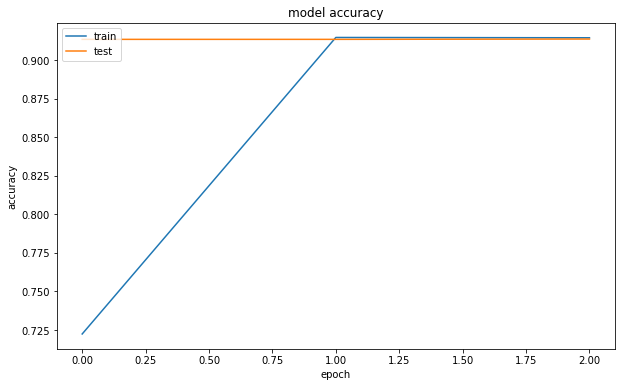

In [37]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 6))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

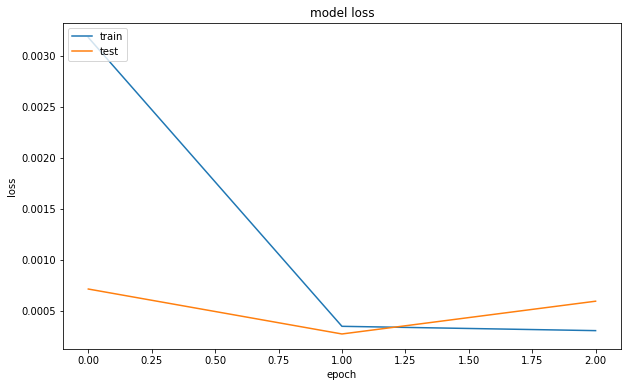

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [39]:
history.history

{'loss': [0.003181014553993009, 0.0003470778977498412, 0.0003047346358653158],
 'accuracy': [0.722425, 0.914725, 0.914525],
 'val_loss': [0.0007128853583708405,
  0.0002719287492800504,
  0.0005934324092231691],
 'val_accuracy': [0.9135, 0.9135, 0.9137]}

In [40]:
"""
# Save model.
with open('text_summary.json',"w").write(model.to_json())
model.load_weights('text_summary.h5')
print("Saved Model!")
"""

'\n# Save model.\nwith open(\'text_summary.json\',"w").write(model.to_json())\nmodel.load_weights(\'text_summary.h5\')\nprint("Saved Model!")\n'

In [ ]:
"""
Bidirectional LSTM: Encoder-Decoder-seq2seq

Room for additions/improvement: 
    -Additional LSTMs
    -LSTM dropout/recurrent_dropout
"""
encoder_inputs = Input(shape=(MAX_LEN,))
encoder_embedding = encoder_embedding_layer(encoder_inputs)
encoder_LSTM = LSTM(HIDDEN_UNITS, return_state=True)
encoder_LSTM_R = LSTM(HIDDEN_UNITS, return_state=True, go_backwards=True)
encoder_outputs_R, state_h_R, state_c_R = encoder_LSTM_R(encoder_embedding)
encoder_outputs, state_h, state_c = encoder_LSTM(encoder_embedding)

final_h = Add()([state_h, state_h_R])
final_c = Add()([state_c, state_c_R])
encoder_states = [final_h, final_c]

"""
decoder
"""
decoder_inputs = Input(shape=(MAX_LEN,))
decoder_embedding = decoder_embedding_layer(decoder_inputs)
decoder_LSTM = LSTM(HIDDEN_UNITS, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_LSTM(decoder_embedding, initial_state=encoder_states) 
decoder_dense = Dense(VOCAB_SIZE, activation='linear')
decoder_outputs = decoder_dense(decoder_outputs)

model= Model(inputs=[encoder_inputs,decoder_inputs], outputs=decoder_outputs)